In [10]:
# Install necessary packages
!pip install matplotlib seaborn pandas --quiet

In [11]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Load datasets
transactions = pd.read_csv('/content/transactions.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')

In [14]:
# Convert 'date' columns to datetime format
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])

# EDA and Visualizations

# 1. Daily Transactions Over Time

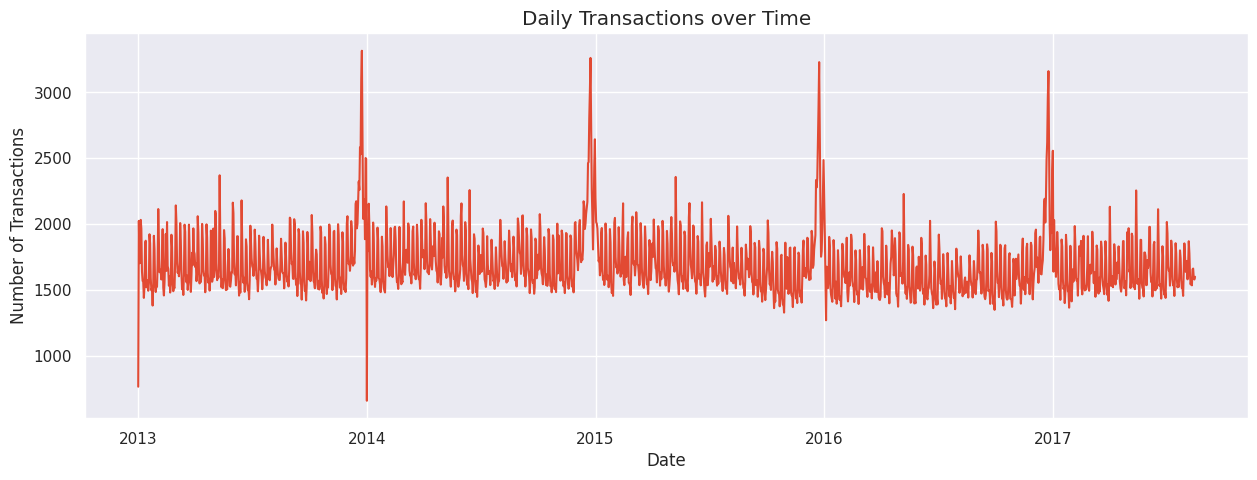

In [15]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=transactions, x='date', y='transactions', ci=None)
plt.title('Daily Transactions over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

# 2. Distribution of Store Types and Clusters

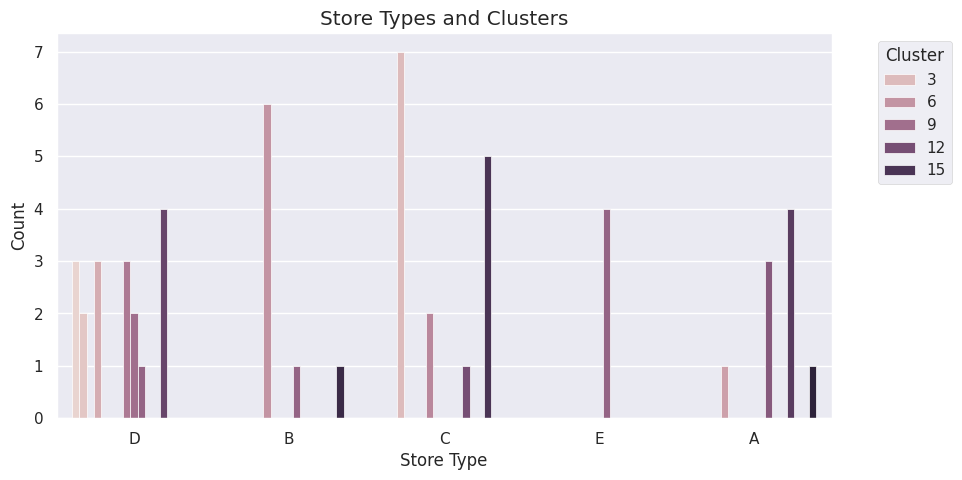

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(data=stores, x='type', hue='cluster')
plt.title('Store Types and Clusters')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 3. Daily Oil Prices Over Time

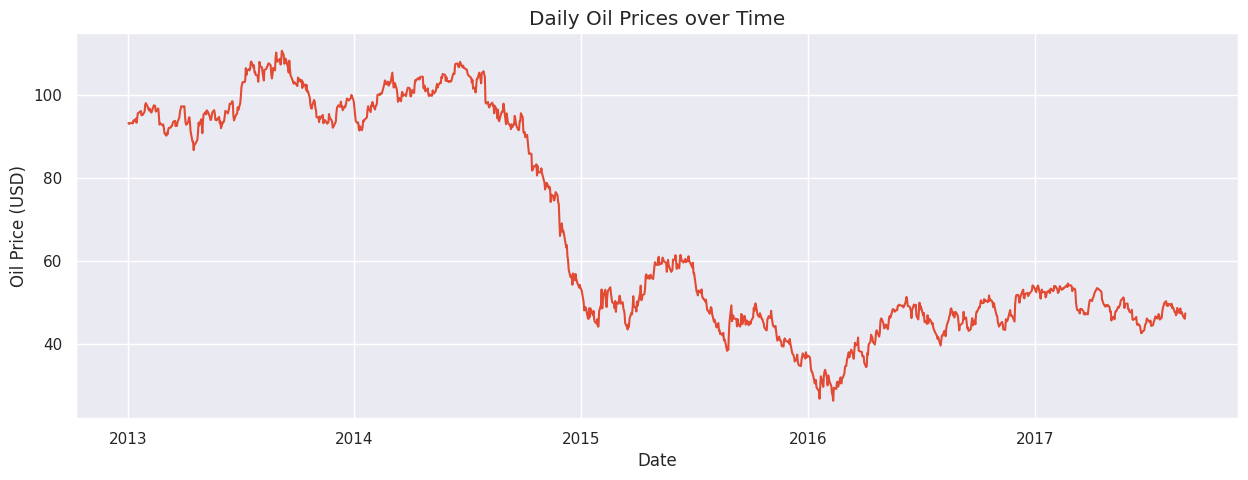

In [17]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=oil, x='date', y='dcoilwtico', ci=None)
plt.title('Daily Oil Prices over Time')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.grid(True)
plt.show()

# 4. Holiday Events by Type

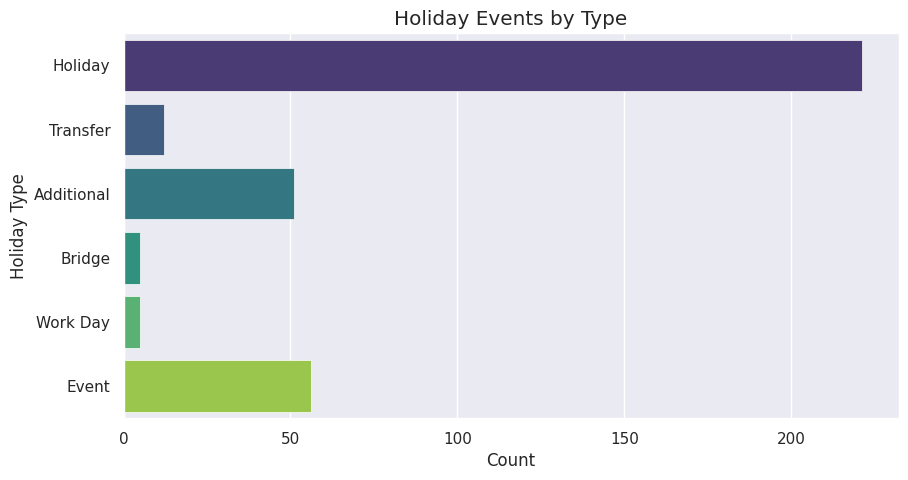

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(data=holidays_events, y='type', palette='viridis')
plt.title('Holiday Events by Type')
plt.xlabel('Count')
plt.ylabel('Holiday Type')
plt.show()

# Correlation between Oil Prices and Transactions



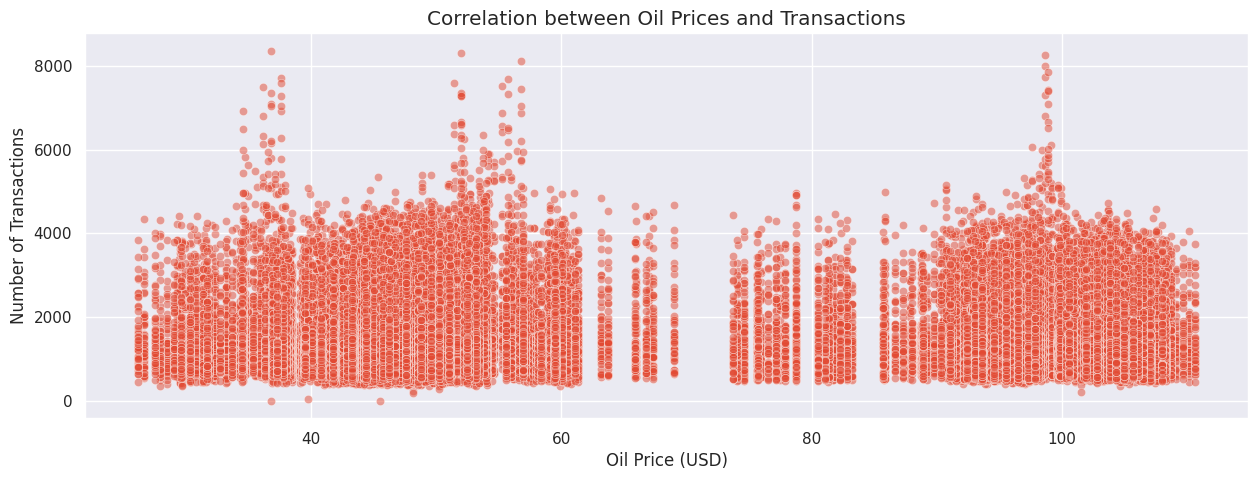

In [19]:
# Merge oil and transaction data on the 'date' column
merged_data = pd.merge(transactions, oil, on='date', how='left')

plt.figure(figsize=(15, 5))
sns.scatterplot(data=merged_data, x='dcoilwtico', y='transactions', alpha=0.5)
plt.title('Correlation between Oil Prices and Transactions')
plt.xlabel('Oil Price (USD)')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

# Impact of Holidays on Transactions

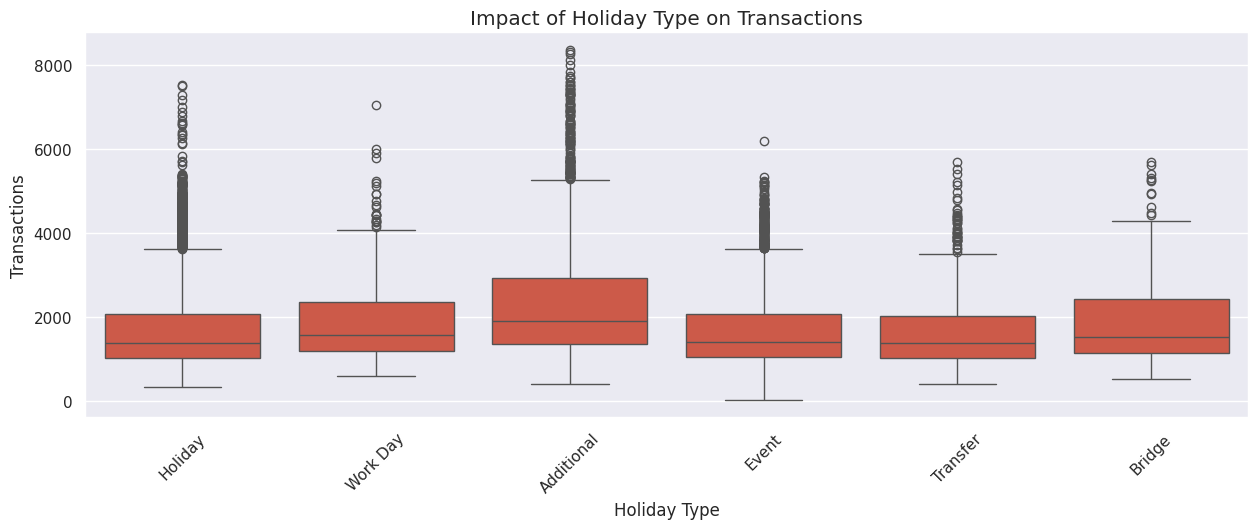

In [20]:
# Merge transactions with holidays data
holiday_transactions = pd.merge(transactions, holidays_events[['date', 'type']], on='date', how='left')

plt.figure(figsize=(15, 5))
sns.boxplot(data=holiday_transactions, x='type', y='transactions')
plt.title('Impact of Holiday Type on Transactions')
plt.xlabel('Holiday Type')
plt.ylabel('Transactions')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Save all visualizations as PNGs
#plt.savefig('daily_transactions.png')
#plt.savefig('store_clusters.png')
#plt.savefig('oil_prices.png')
#plt.savefig('holiday_types.png')

In [21]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler

# Reload datasets
transactions = pd.read_csv('/content/transactions.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')

In [22]:
# Convert date columns to datetime format
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])

In [23]:
# 1. Handle Missing Values in Oil Prices (forward-fill missing values)
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(method='ffill')

# Check for missing values in each dataset
transactions_missing = transactions.isnull().sum()
holidays_events_missing = holidays_events.isnull().sum()
oil_missing = oil.isnull().sum()
stores_missing = stores.isnull().sum()

In [24]:
# Display the column names in holidays_events to check for 'type'
print(holidays_events.columns)


Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')


In [25]:
# Ensure 'date' columns are in datetime format for all datasets
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])

# 1. Merge transactions with stores on 'store_nbr'
merged_data = pd.merge(transactions, stores, on='store_nbr', how='left')

# 2. Merge the resulting data with oil prices on 'date'
merged_data = pd.merge(merged_data, oil, on='date', how='left')

# 3. Merge with holidays_events to add holiday information
try:
    merged_data = pd.merge(merged_data, holidays_events[['date', 'type']], on='date', how='left')
    # Encode holiday type into numeric values
    merged_data['holiday_type_encoded'] = merged_data['type'].factorize()[0]
except KeyError:
    # If the 'type' column is not found during merging, handle the error
    print("Column 'type' not found after merging. Creating a default 'holiday_type_encoded' column.")
    merged_data['holiday_type_encoded'] = -1  # Assign a default value

# Display the first few rows of the merged data to verify
merged_data.head()

Column 'type' not found after merging. Creating a default 'holiday_type_encoded' column.


,date,store_nbr,transactions,city,state,type_x,cluster,dcoilwtico,type_y,holiday_type_encoded
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,NaN,Holiday,-1
1,2013-01-02,1,2111,Quito,Pichincha,D,13,93.14,NaN,-1
2,2013-01-02,2,2358,Quito,Pichincha,D,13,93.14,NaN,-1
3,2013-01-02,3,3487,Quito,Pichincha,D,8,93.14,NaN,-1
4,2013-01-02,4,1922,Quito,Pichincha,D,9,93.14,NaN,-1


In [26]:
# 3. Create New Features
# Extract year, month, day, and day of week from 'date' for time-series analysis
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek

# Flag if the day is a weekend
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5, 6]).astype(int)

In [27]:
# Import numpy
import numpy as np

# 4. Handle Outliers in Transactions (Winsorization)
q1 = merged_data['transactions'].quantile(0.01)
q99 = merged_data['transactions'].quantile(0.99)
merged_data['transactions_clipped'] = np.clip(merged_data['transactions'], q1, q99)

In [28]:
# 5. Normalize or Scale Features (for Models)
scaler = MinMaxScaler()
merged_data[['transactions_scaled', 'dcoilwtico_scaled']] = scaler.fit_transform(
    merged_data[['transactions', 'dcoilwtico']])

In [29]:
# Data Summary after Preprocessing
merged_data_summary = merged_data.describe()

# Save processed data
merged_data.to_csv("/content/processed_data.csv", index=False)

# Display summary and missing value checks
transactions_missing, holidays_events_missing, oil_missing, stores_missing, merged_data_summary

(date            0
 store_nbr       0
 transactions    0
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
 date          0
 dcoilwtico    1
 dtype: int64,
 store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
        store_nbr  transactions   cluster  dcoilwtico  holiday_type_encoded  \
 count  85,007.00     85,007.00 85,007.00   60,544.00             85,007.00   
 mean       26.94      1,697.07      8.53       66.66                 -1.00   
 std        15.61        966.84      4.72       25.47                  0.00   
 min         1.00          5.00      1.00       26.19                 -1.00   
 25%        13.00      1,046.00      4.00       46.17                 -1.00   
 50%        27.00      1,395.00      9.00       52.74                 -1.00   
 75%        40.00      2,081.00     13.00       95.25                 -1.00   
 max        54.00      8,359.

In [30]:
# Import necessary libraries
import pandas as pd

# Load the train.csv file
train = pd.read_csv("/content/sample_data/train.csv", delimiter=',', engine='python', on_bad_lines='skip')

# Check the column names again to ensure they are correctly parsed
print(train.columns)

# Display the first few rows to understand the structure
train.head()

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00


In [31]:
# Check for missing values in each column
missing_values = train.isnull().sum()

# Get a summary of the dataset
train_info = train.info()

# Display missing values and dataset info
missing_values, train_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236075 entries, 0 to 2236074
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           object 
 1   date         object 
 2   store_nbr    object 
 3   family       object 
 4   sales        float64
 5   onpromotion  float64
dtypes: float64(2), object(4)
memory usage: 102.4+ MB


(id             0
 date           0
 store_nbr      3
 family         4
 sales          6
 onpromotion    7
 dtype: int64,
 None)

In [32]:
# Generate descriptive statistics to understand the data distribution
train_summary = train.describe()

train_summary

,sales,onpromotion
count,"2,236,069.00","2,236,068.00"
mean,390.98,3.44
std,"1,174.55",13.96
min,0.00,0.00
25%,0.00,0.00
50%,15.00,0.00
75%,219.00,1.00
max,"124,717.00",741.00


In [33]:
# Display the column names in the train DataFrame
print(train.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


Step 4: Visualize the Sales Distribution

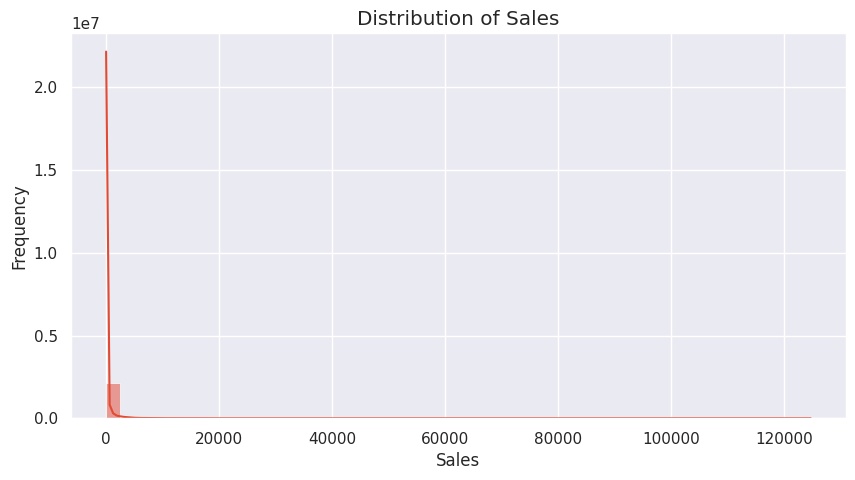

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of sales
plt.figure(figsize=(10, 5))
sns.histplot(train['sales'], bins=50, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [35]:
# Convert 'date' column to datetime, coercing errors
train['date'] = pd.to_datetime(train['date'], errors='coerce')

# Check for rows where the date conversion failed
invalid_dates = train[train['date'].isna()]
print("Invalid dates found:\n", invalid_dates)

Invalid dates found:
                  id date  store_nbr               family  sales  onpromotion
27508         27508  NaT         25           LADIESWEAR   0.00         0.00
80461   5470/BAKERY  NaT          1                 None    NaN          NaN
211415      1161656  NaT        0.0                    0    NaN          NaN
237916   1353520-15  NaT  MAGAZINES                  0.0   0.00          NaN
315621      1212865  NaT        0.0                    0    NaN          NaN
342120       188349  NaT          4  HOME AND KITCHEN II   7.00         0.00
498260      26724.0  NaT       None                 None    NaN          NaN


In [36]:
# Remove rows with invalid dates
train = train.dropna(subset=['date'])

# Check if the data has been cleaned
print("Data after removing invalid dates:\n", train.head())

Data after removing invalid dates:
   id                 date store_nbr      family  sales  onpromotion
0  0  2013-01-01 00:00:00         1  AUTOMOTIVE   0.00         0.00
1  1  2013-01-01 00:00:00         1   BABY CARE   0.00         0.00
2  2  2013-01-01 00:00:00         1      BEAUTY   0.00         0.00
3  3  2013-01-01 00:00:00         1   BEVERAGES   0.00         0.00
4  4  2013-01-01 00:00:00         1       BOOKS   0.00         0.00


In [37]:
# Fill missing numeric values with 0 (or use another strategy if needed)
train['sales'] = train['sales'].fillna(0)
train['onpromotion'] = train['onpromotion'].fillna(0)

# Fill missing categorical values with 'Unknown'
train['family'] = train['family'].fillna('Unknown')
train['store_nbr'] = train['store_nbr'].fillna('Unknown')

#Step 5: Analyze Sales Over Time

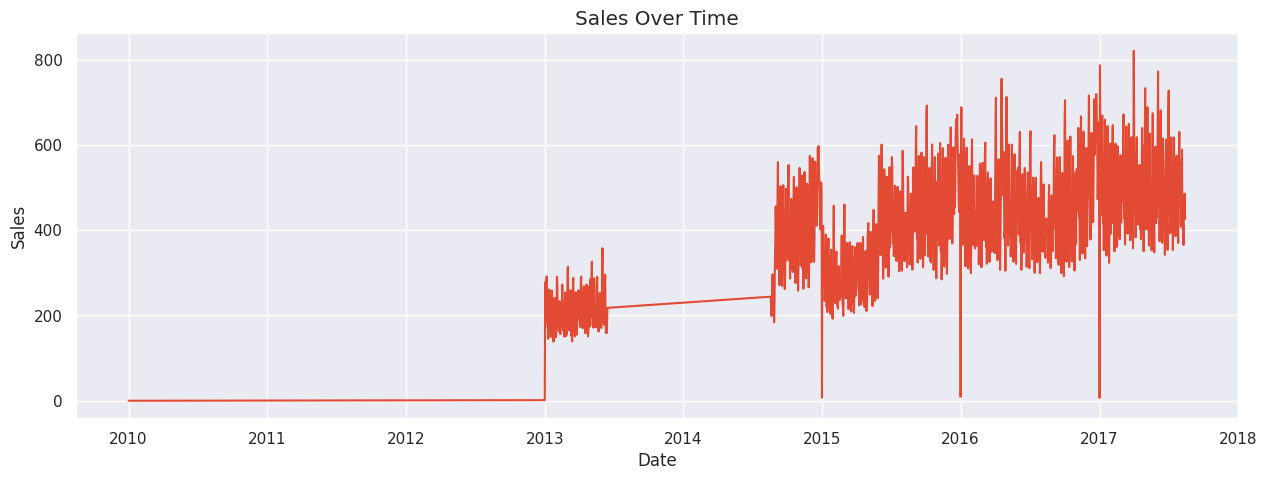

In [38]:
# Plot sales over time after cleaning
plt.figure(figsize=(15, 5))
sns.lineplot(data=train, x='date', y='sales', ci=None)
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

Step 6: Visualize Sales by Product Family

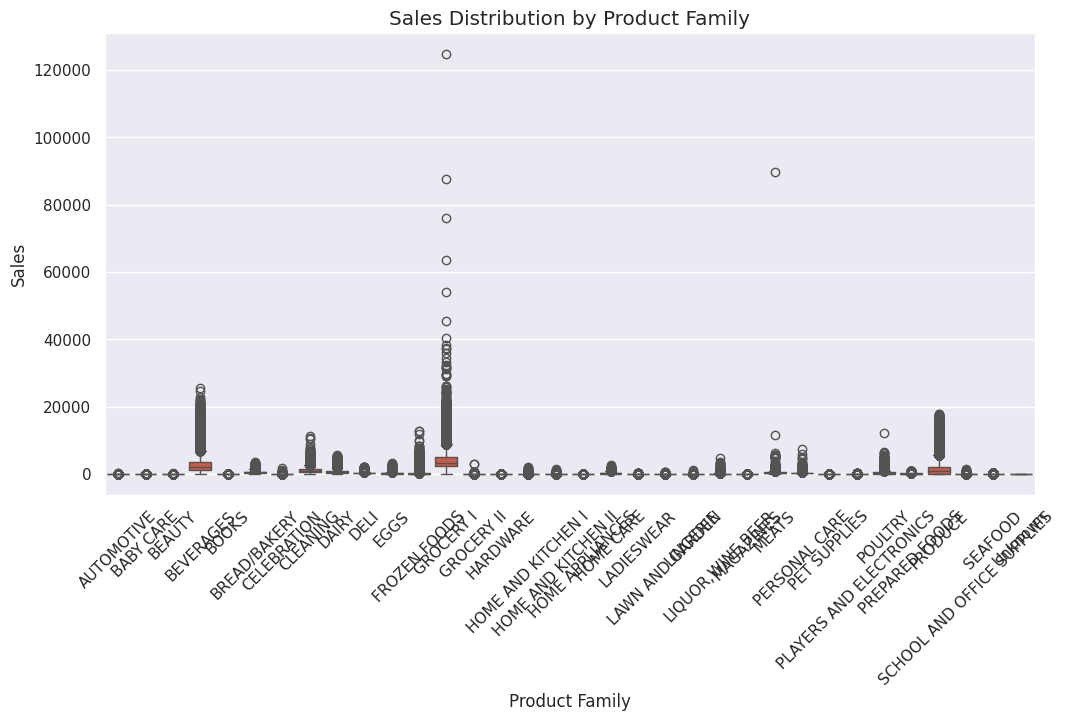

In [39]:
# Plot sales distribution across different product families
plt.figure(figsize=(12, 6))
sns.boxplot(data=train, x='family', y='sales')
plt.title('Sales Distribution by Product Family')
plt.xlabel('Product Family')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

Step 7: Analyze the Impact of Promotions on Sales

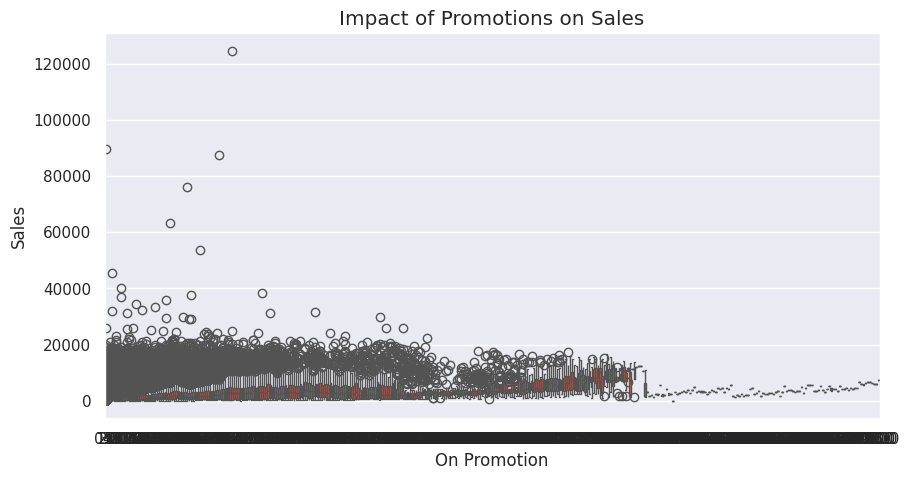

In [40]:
 # Plot sales with and without promotions
plt.figure(figsize=(10, 5))
sns.boxplot(data=train, x='onpromotion', y='sales')
plt.title('Impact of Promotions on Sales')
plt.xlabel('On Promotion')
plt.ylabel('Sales')
plt.show()

In [41]:
# Import necessary libraries
import pandas as pd

# Load datasets
train = pd.read_csv("/content/sample_data/train.csv", on_bad_lines='skip')
transactions = pd.read_csv('/content/transactions.csv')
holidays_events = pd.read_csv('/content/holidays_events.csv')
oil = pd.read_csv('/content/oil.csv')
stores = pd.read_csv('/content/stores.csv')

In [42]:
# Display the first few rows of each dataset
print("Train Data Sample:\n", train.head())
print("Transactions Data Sample:\n", transactions.head())
print("Oil Data Sample:\n", oil.head())
print("Holidays Events Data Sample:\n", holidays_events.head())
print("Stores Data Sample:\n", stores.head())

Train Data Sample:
   id        date store_nbr      family  sales  onpromotion
0  0  2013-01-01         1  AUTOMOTIVE   0.00         0.00
1  1  2013-01-01         1   BABY CARE   0.00         0.00
2  2  2013-01-01         1      BEAUTY   0.00         0.00
3  3  2013-01-01         1   BEVERAGES   0.00         0.00
4  4  2013-01-01         1       BOOKS   0.00         0.00
Transactions Data Sample:
          date  store_nbr  transactions
0  2013-01-01         25           770
1  2013-01-02          1          2111
2  2013-01-02          2          2358
3  2013-01-02          3          3487
4  2013-01-02          4          1922
Oil Data Sample:
          date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20
Holidays Events Data Sample:
          date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  

In [43]:
# Convert 'date' columns to datetime format
train['date'] = pd.to_datetime(train['date'], errors='coerce')
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

# Check for any issues in date conversion in the train data
print("Train Data Invalid Dates:\n", train[train['date'].isna()])

Train Data Invalid Dates:
                  id date  store_nbr               family  sales  onpromotion
27508         27508  NaT         25           LADIESWEAR   0.00         0.00
80461   5470/BAKERY  NaT          1                  NaN    NaN          NaN
211415      1161656  NaT        0.0                    0    NaN          NaN
237916   1353520-15  NaT  MAGAZINES                  0.0   0.00          NaN
315621      1212865  NaT       0.00                    0    NaN          NaN
342120       188349  NaT       4.00  HOME AND KITCHEN II   7.00         0.00
498260    26,724.00  NaT        NaN                  NaN    NaN          NaN


In [44]:
# Remove rows with invalid dates
train = train.dropna(subset=['date'])

# Display the cleaned train data
print("Cleaned Train Data Sample:\n", train.head())


Cleaned Train Data Sample:
   id                 date store_nbr      family  sales  onpromotion
0  0  2013-01-01 00:00:00         1  AUTOMOTIVE   0.00         0.00
1  1  2013-01-01 00:00:00         1   BABY CARE   0.00         0.00
2  2  2013-01-01 00:00:00         1      BEAUTY   0.00         0.00
3  3  2013-01-01 00:00:00         1   BEVERAGES   0.00         0.00
4  4  2013-01-01 00:00:00         1       BOOKS   0.00         0.00


In [45]:
# Fill missing values in 'sales' and 'onpromotion' with 0
train['sales'] = train['sales'].fillna(0)
train['onpromotion'] = train['onpromotion'].fillna(0)

# Fill missing values in 'family' with 'Unknown'
train['family'] = train['family'].fillna('Unknown')

# Display the cleaned train data
print("Train Data After Handling Missing Values:\n", train.head())

Train Data After Handling Missing Values:
   id                 date store_nbr      family  sales  onpromotion
0  0  2013-01-01 00:00:00         1  AUTOMOTIVE   0.00         0.00
1  1  2013-01-01 00:00:00         1   BABY CARE   0.00         0.00
2  2  2013-01-01 00:00:00         1      BEAUTY   0.00         0.00
3  3  2013-01-01 00:00:00         1   BEVERAGES   0.00         0.00
4  4  2013-01-01 00:00:00         1       BOOKS   0.00         0.00


In [61]:
# Extract year, month, day, and day of the week from the 'date' column
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['day'] = merged_data['date'].dt.day
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek

# Create a flag for weekends (Saturday=5, Sunday=6)
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5, 6]).astype(int)

# Create a flag for holidays (if 'type_y' is not NaN, it is a holiday)
merged_data['is_holiday'] = merged_data['type_y'].notna().astype(int)

# Display the data with the new features
print("Data with New Features:\n", merged_data.head())

Data with New Features:
   id       date store_nbr      family  sales  onpromotion   city      state  \
0  0 2013-01-01         1  AUTOMOTIVE    0.0          0.0  Quito  Pichincha   
1  1 2013-01-01         1   BABY CARE    0.0          0.0  Quito  Pichincha   
2  2 2013-01-01         1      BEAUTY    0.0          0.0  Quito  Pichincha   
3  3 2013-01-01         1   BEVERAGES    0.0          0.0  Quito  Pichincha   
4  4 2013-01-01         1       BOOKS    0.0          0.0  Quito  Pichincha   

  type_x  cluster  ...    locale  locale_name         description transferred  \
0      D     13.0  ...  National      Ecuador  Primer dia del ano       False   
1      D     13.0  ...  National      Ecuador  Primer dia del ano       False   
2      D     13.0  ...  National      Ecuador  Primer dia del ano       False   
3      D     13.0  ...  National      Ecuador  Primer dia del ano       False   
4      D     13.0  ...  National      Ecuador  Primer dia del ano       False   

   year month

#Handling Categorical data

In [62]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns to encode
categorical_columns = ['family', 'city', 'state', 'type_x', 'locale', 'locale_name']

# Apply label encoding to each categorical column
label_encoder = LabelEncoder()
for column in categorical_columns:
    merged_data[column] = label_encoder.fit_transform(merged_data[column].astype(str))

# Display the data after encoding
print("Data After Encoding Categorical Variables:\n", merged_data.head())

Data After Encoding Categorical Variables:
   id       date store_nbr  family  sales  onpromotion  city  state  type_x  \
0  0 2013-01-01         1       0    0.0          0.0    18     12       3   
1  1 2013-01-01         1       1    0.0          0.0    18     12       3   
2  2 2013-01-01         1       2    0.0          0.0    18     12       3   
3  3 2013-01-01         1       3    0.0          0.0    18     12       3   
4  4 2013-01-01         1       4    0.0          0.0    18     12       3   

   cluster  ...  locale  locale_name         description  transferred  year  \
0     13.0  ...       1            4  Primer dia del ano        False  2013   
1     13.0  ...       1            4  Primer dia del ano        False  2013   
2     13.0  ...       1            4  Primer dia del ano        False  2013   
3     13.0  ...       1            4  Primer dia del ano        False  2013   
4     13.0  ...       1            4  Primer dia del ano        False  2013   

  month day 

In [63]:
# Final check for any remaining missing values
print("Remaining Missing Values in Merged Data:\n", merged_data.isnull().sum())

# Save the cleaned and prepared dataset
merged_data.to_csv("/content/prepared_data_for_modeling.csv", index=False)
print("Prepared data saved successfully at /content/prepared_data_for_modeling.csv")

Remaining Missing Values in Merged Data:
 id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type_x                0
cluster          131069
transactions          0
dcoilwtico         1782
type_y          1904614
locale                0
locale_name           0
description     1904614
transferred     1904614
year                  0
month                 0
day                   0
day_of_week           0
is_weekend            0
is_holiday            0
dtype: int64
Prepared data saved successfully at /content/prepared_data_for_modeling.csv


In [64]:
# Impute missing values in 'cluster' with the mode (most common value)
merged_data['cluster'] = merged_data['cluster'].fillna(merged_data['cluster'].mode()[0])

# Impute missing values in 'dcoilwtico' using forward-fill and backward-fill
merged_data['dcoilwtico'] = merged_data['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

# Fill 'type_y', 'description', and 'transferred' with 'Unknown' or 'False'
merged_data['type_y'] = merged_data['type_y'].fillna('Unknown')
merged_data['description'] = merged_data['description'].fillna('Unknown')
merged_data['transferred'] = merged_data['transferred'].fillna(False)

# Display the remaining missing values
print("Remaining Missing Values After Imputation:\n", merged_data.isnull().sum())

<ipython-input-64-6f2e5d240383>:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_data['dcoilwtico'] = merged_data['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
<ipython-input-64-6f2e5d240383>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data['transferred'] = merged_data['transferred'].fillna(False)


Remaining Missing Values After Imputation:
 id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
type_x          0
cluster         0
transactions    0
dcoilwtico      0
type_y          0
locale          0
locale_name     0
description     0
transferred     0
year            0
month           0
day             0
day_of_week     0
is_weekend      0
is_holiday      0
dtype: int64


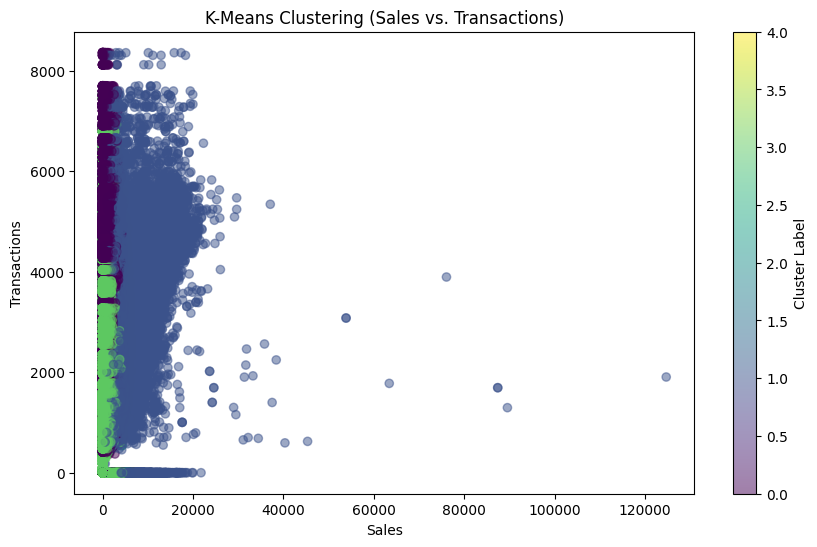

Data with Cluster Labels:
   id       date store_nbr  family  sales  onpromotion  city  state  type_x  \
0  0 2013-01-01         1       0    0.0          0.0    18     12       3   
1  1 2013-01-01         1       1    0.0          0.0    18     12       3   
2  2 2013-01-01         1       2    0.0          0.0    18     12       3   
3  3 2013-01-01         1       3    0.0          0.0    18     12       3   
4  4 2013-01-01         1       4    0.0          0.0    18     12       3   

   cluster  ...  locale_name         description transferred  year  month day  \
0     13.0  ...            4  Primer dia del ano       False  2013      1   1   
1     13.0  ...            4  Primer dia del ano       False  2013      1   1   
2     13.0  ...            4  Primer dia del ano       False  2013      1   1   
3     13.0  ...            4  Primer dia del ano       False  2013      1   1   
4     13.0  ...            4  Primer dia del ano       False  2013      1   1   

   day_of_week  i

In [65]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering (excluding non-numeric and date columns)
features = merged_data[['sales', 'onpromotion', 'transactions', 'dcoilwtico', 'year', 'month', 'day', 'day_of_week']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform K-Means clustering with an appropriate number of clusters (e.g., 5)
kmeans = KMeans(n_clusters=5, random_state=42)
merged_data['cluster_label'] = kmeans.fit_predict(features_scaled)

# Plot the clusters to visualize the distribution (use sales vs. transactions as an example)
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['sales'], merged_data['transactions'], c=merged_data['cluster_label'], cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering (Sales vs. Transactions)')
plt.xlabel('Sales')
plt.ylabel('Transactions')
plt.colorbar(label='Cluster Label')
plt.show()

# Display the data with cluster labels
print("Data with Cluster Labels:\n", merged_data.head())

In [66]:
import numpy as np

# Calculate the distance of each point from the cluster center
distances = np.linalg.norm(features_scaled - kmeans.cluster_centers_[merged_data['cluster_label']], axis=1)

# Define a threshold for anomalies (e.g., 95th percentile of distances)
threshold = np.percentile(distances, 95)

# Flag anomalies
merged_data['is_anomaly'] = (distances > threshold).astype(int)

# Display the number of anomalies detected
num_anomalies = merged_data['is_anomaly'].sum()
print(f"Number of anomalies detected: {num_anomalies}")

# Display a sample of flagged anomalies
anomalies = merged_data[merged_data['is_anomaly'] == 1]
print("Sample of Anomalies:\n", anomalies.head())

Number of anomalies detected: 113764
Sample of Anomalies:
         id       date store_nbr  family   sales  onpromotion  city  state  \
1851  1851 2013-01-02        11       3  3443.0          0.0     2     12   
1855  1855 2013-01-02        11       7  3260.0          0.0     2     12   
1860  1860 2013-01-02        11      12  7736.0          0.0     2     12   
2091  2091 2013-01-02        18      12  3756.0          0.0    18     12   
2157  2157 2013-01-02         2      12  3870.0          0.0    18     12   

      type_x  cluster  ...  description  transferred  year  month  day  \
1851       1      6.0  ...      Unknown        False  2013      1    2   
1855       1      6.0  ...      Unknown        False  2013      1    2   
1860       1      6.0  ...      Unknown        False  2013      1    2   
2091       1     16.0  ...      Unknown        False  2013      1    2   
2157       3     13.0  ...      Unknown        False  2013      1    2   

     day_of_week  is_weekend  is_

In [67]:
# Remove anomalies from the dataset
cleaned_data = merged_data[merged_data['is_anomaly'] == 0].copy()

# Drop the 'is_anomaly' column as it's no longer needed
cleaned_data = cleaned_data.drop(columns=['is_anomaly'])

# Display the number of records remaining after removing anomalies
print(f"Number of records after removing anomalies: {len(cleaned_data)}")

# Display a sample of the cleaned data
print("Sample of Cleaned Data:\n", cleaned_data.head())

Number of records after removing anomalies: 2161504
Sample of Cleaned Data:
   id       date store_nbr  family  sales  onpromotion  city  state  type_x  \
0  0 2013-01-01         1       0    0.0          0.0    18     12       3   
1  1 2013-01-01         1       1    0.0          0.0    18     12       3   
2  2 2013-01-01         1       2    0.0          0.0    18     12       3   
3  3 2013-01-01         1       3    0.0          0.0    18     12       3   
4  4 2013-01-01         1       4    0.0          0.0    18     12       3   

   cluster  ...  locale_name         description transferred  year  month day  \
0     13.0  ...            4  Primer dia del ano       False  2013      1   1   
1     13.0  ...            4  Primer dia del ano       False  2013      1   1   
2     13.0  ...            4  Primer dia del ano       False  2013      1   1   
3     13.0  ...            4  Primer dia del ano       False  2013      1   1   
4     13.0  ...            4  Primer dia del ano 

In [1]:
# Install AutoVIML
!pip install autoviml!pip install autoviml
!pip uninstall scipy -y
!pip install scipy==1.7.3
!pip uninstall numpy scipy autoviml -y
!pip uninstall numpy matplotlib scipy -y
!pip install numpy==1.22.4 matplotlib==3.5.3 scipy==1.7.3
!pip install numpy==1.23.5 scipy==1.9.3
!pip install autoviml==0.1.800

ERROR: Invalid requirement: 'autoviml!pip': Expected end or semicolon (after name and no valid version specifier)
    autoviml!pip
            ^
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 50.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.22.4 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.7.3 which i

Found existing installation: numpy 1.22.4
Uninstalling numpy-1.22.4:
  Successfully uninstalled numpy-1.22.4
Found existing installation: scipy 1.7.3
Uninstalling scipy-1.7.3:
  Successfully uninstalled scipy-1.7.3
Found existing installation: matplotlib 3.8.0
Uninstalling matplotlib-3.8.0:
  Successfully uninstalled matplotlib-3.8.0
  Using cached numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached scipy-1.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.2 kB)
Using cached numpy-1.22.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 64.4 MB/s eta 0:00:00
Using cached scipy-1.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.20 requires scipy>=1.10.0, but you have scipy 1.9.3 which is incompatible.
bigframes 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of imbalanced-ensemble to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.5/746.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/9

In [1]:
# Import necessary libraries
from autoviml.Auto_ViML import Auto_ViML

Imported Auto_ViML version: 0.1.800. Call using:
             m, feats, trainm, testm = Auto_ViML(train, target, test,
                            sample_submission='',
                            scoring_parameter='', KMeans_Featurizer=False,
                            hyper_param='RS',feature_reduction=True,
                             Boosting_Flag='CatBoost', Binning_Flag=False,
                            Add_Poly=0, Stacking_Flag=False,Imbalanced_Flag=False,
                            GPU_flag=False, verbose=1)
            

Imported Auto_NLP version: 0.1.01.. Call using:
     train_nlp, test_nlp, nlp_pipeline, predictions = Auto_NLP(
                nlp_column, train, test, target, score_type='balanced_accuracy',
                modeltype='Classification',top_num_features=200, verbose=0,
                build_model=True)


In [3]:
import pandas as pd

# Load the saved prepared data
merged_data = pd.read_csv("/content/prepared_data_for_modeling.csv")

# Display the first few rows of the loaded data
print("Loaded Merged Data Sample:\n", merged_data.head())

Loaded Merged Data Sample:
     id        date  store_nbr  family  sales  onpromotion  city  state  \
0 0.00  2013-01-01       1.00       0   0.00         0.00    18     12   
1 1.00  2013-01-01       1.00       1   0.00         0.00    18     12   
2 2.00  2013-01-01       1.00       2   0.00         0.00    18     12   
3 3.00  2013-01-01       1.00       3   0.00         0.00    18     12   
4 4.00  2013-01-01       1.00       4   0.00         0.00    18     12   

   type_x  cluster  transactions  dcoilwtico   type_y  locale  locale_name  \
0       3    13.00          0.00         NaN  Holiday       1            4   
1       3    13.00          0.00         NaN  Holiday       1            4   
2       3    13.00          0.00         NaN  Holiday       1            4   
3       3    13.00          0.00         NaN  Holiday       1            4   
4       3    13.00          0.00         NaN  Holiday       1            4   

          description transferred  year  month  day  day_o

In [4]:
# Handle missing values in the 'cluster' column by filling with -1
merged_data['cluster'] = merged_data['cluster'].fillna(-1).astype(int)

# Correct data types for other columns
merged_data['id'] = merged_data['id'].astype(int)
merged_data['store_nbr'] = merged_data['store_nbr'].astype(int)

# Check the data types to confirm the changes
print("Data Types After Correction:\n", merged_data.dtypes)


Data Types After Correction:
 id                int64
date             object
store_nbr         int64
family            int64
sales           float64
onpromotion     float64
city              int64
state             int64
type_x            int64
cluster           int64
transactions    float64
dcoilwtico      float64
type_y           object
locale            int64
locale_name       int64
description      object
transferred      object
year              int64
month             int64
day               int64
day_of_week       int64
is_weekend        int64
is_holiday        int64
dtype: object


##############  D A T A   S E T  A N A L Y S I S  #######################
ALERT! Changing hyperparameter search to RS. Otherwise, Random Forests will take too long for 10,000+ rows
Training Set Shape = (182021, 23)
    Training Set Memory Usage = 33.33 MB
Test Set Shape = (45506, 22)
    Test Set Memory Usage = 7.99 MB
Single_Label Target: ['sales']

################ Regression VISUALIZATION Started #####################
No shuffling of data set before training...
    Using RandomizedSearchCV for Hyper Parameter Tuning. This is 3X faster than GridSearchCV...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  3
    Number of Integer-Categorical Columns =  12
    Number of String-Categorical Columns =  2
    N

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Auto NLP processing on NLP Column: date
Shape of Train Data: 182021 rows
    Shape of Test Data: 45506 rows
    Added 9 summary columns for counts of words and characters in each row
Cleaning text in date column. Please be patient since this is a large dataset with >100K rows...
    Faster text processing using clean_tweets function, since top_num_features exceeds 300
Train data Text cleaning completed. Time taken = 58 seconds
##################    THIS IS FOR BUILD_MODEL = FALSE           #################
Building Model and Pipeline for NLP column = date. This will take time...
Auto_NLP error. Continuing without NLP processing
Processing year column for date time features....
    Adding 1 columns from date-time column year in train
        Adding time series features for test data...
#######################################################################################
#####  SULOV:  Searching for Uncorrelated List Of Variables in 3 features ############
############################

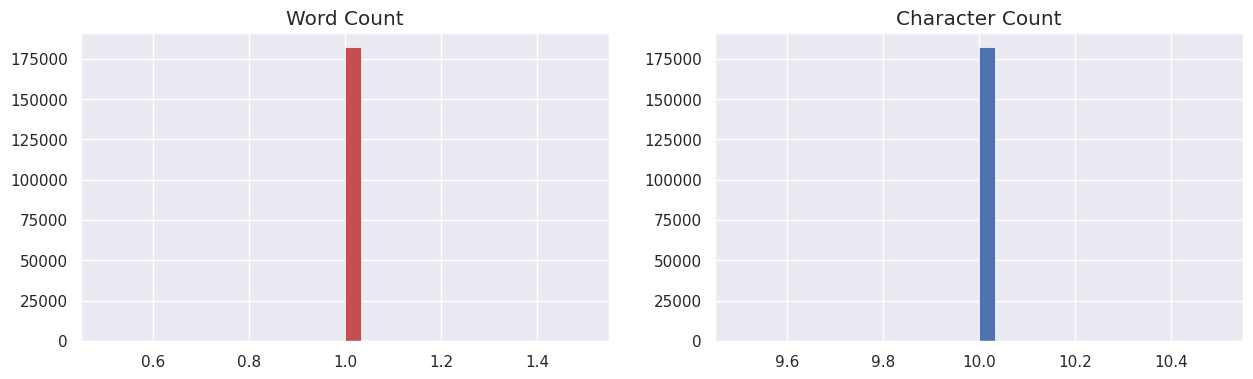

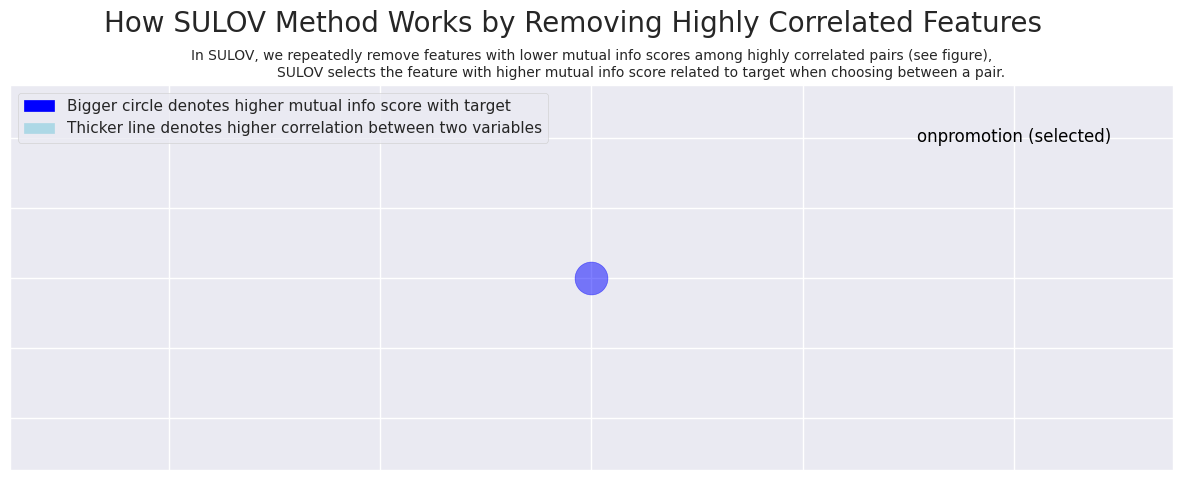

Splitting selected features into float and categorical (integer) variables:
    (3) float variables ...
    (23) categorical vars...
###############################################################################
#######     F E A T U R E   S E L E C T I O N    BY   X G B O O S T    ########
###############################################################################
Current number of predictors = 26 
    Finding Important Features using Boosted Trees algorithm...
        using 26 variables...
        using 21 variables...
        using 16 variables...
        using 11 variables...
        using 6 variables...
Found 18 important features
    Performing limited feature engineering for binning, add_poly and KMeans_Featurizer flags  ...
    Train CV Split completed with TRAIN rows =  145616 , CV rows =  36405
    Binning_Flag set to False or there are no float vars in data set to be binned
    KMeans_Featurizer set to False or there are no float variables in data
Performing MinMax scal

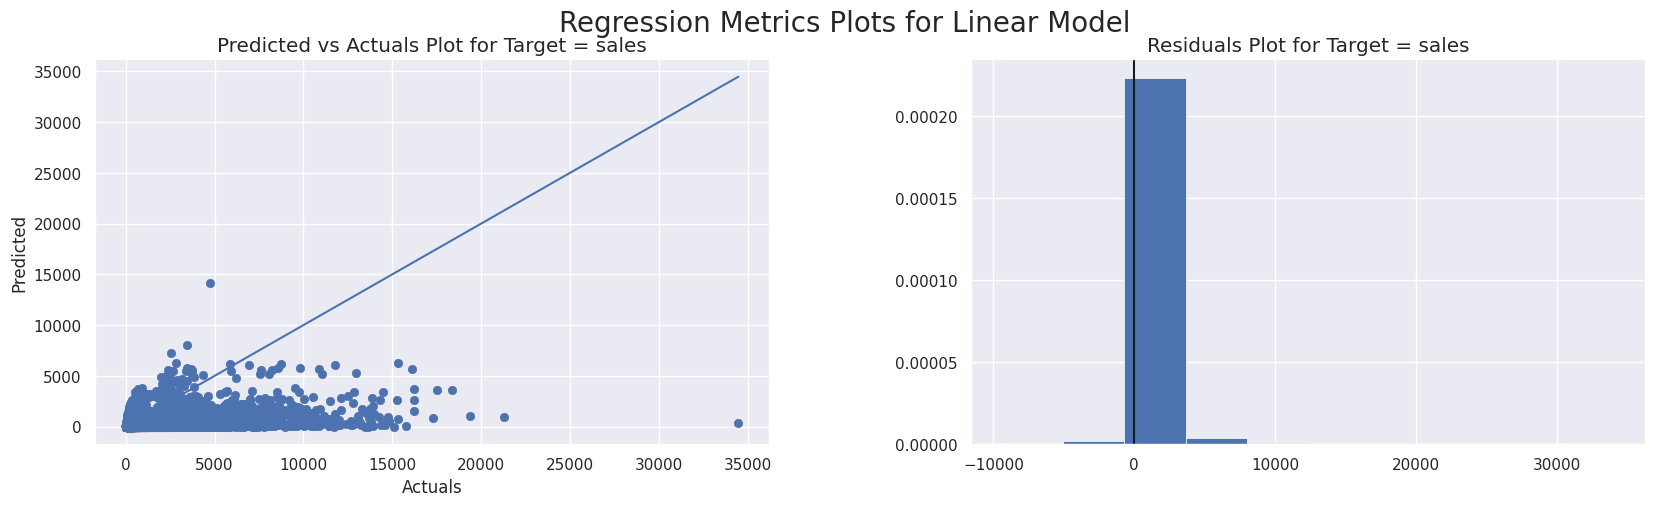

<Figure size 1500x500 with 0 Axes>

In [5]:
# Import necessary libraries
import pandas as pd
from autoviml.Auto_ViML import Auto_ViML
from sklearn.model_selection import train_test_split

# Define features and target
features = merged_data.drop(columns=['id', 'date', 'description', 'transferred', 'sales'])  # Exclude non-predictive columns
target = 'sales'  # Target variable is 'sales'

# Reduce the data size by taking a 10% random sample
sampled_data = merged_data.sample(frac=0.1, random_state=42)

# Split the sampled data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    sampled_data.drop(columns=['sales']),
    sampled_data['sales'],
    test_size=0.2,
    random_state=42
)

# Combine X_train and y_train into a single DataFrame for AutoVIML
train_data = pd.concat([X_train, y_train], axis=1)

# Run AutoVIML on the reduced data
model, features, trainm, testm = Auto_ViML(
    train=train_data,
    target=target,
    test=X_valid,
    sample_submission='',  # Leave this empty for regression
    hyper_param='RS',      # Use Random Search for hyperparameter tuning
    feature_reduction=True, # Reduce features if needed
    scoring_parameter='r2', # Metric to optimize (e.g., 'r2' for regression)
    Boosting_Flag=None,    # Auto-detect the best boosting algorithm
    verbose=1              # Set verbosity for more details
)

# Display the model summary
print("AutoVIML Model Summary:\n", model)